In [1]:
from glob import glob

import numpy as np

from geopandas import GeoDataFrame, points_from_xy
from numpy.typing import NDArray
from pandas import concat, DataFrame, DatetimeIndex, NamedAgg, read_csv, to_datetime
from sklearn.metrics import pairwise_distances
from skmob import TrajDataFrame

In [2]:
# data_files = glob("./data/unipi_ais/synopses/2018/*.csv")

# raw_data: DataFrame = (
#     read_csv(data_files[0])
#         .rename(columns=str.upper)
#         .rename(columns={"T": "EPOCH"})
#         .pipe(lambda df_:
#             df_
#                 .assign(
#                     EPOCH=df_.EPOCH / 1000,
#                     ANNOTATIONS=df_.ANNOTATIONS.astype("string").str.replace(r"\[|\]|'| ", "", regex=True),
#                     HEADING=df_.HEADING.round(3).astype("float32"),
#                     SPEED=df_.SPEED.round(3).astype("float32"),
#                 )
#                 .loc[
#                     df_.VESSEL_ID.isin(df_.groupby("VESSEL_ID").agg("count").query("EPOCH>4").index)
#                 ]
#         )
#         .sort_values(by="EPOCH", ascending=True)
#         .reset_index(drop=True)
#         .astype({"VESSEL_ID": "string", "EPOCH": "int64"})
#         .reindex(
#             columns=["EPOCH", "VESSEL_ID", "LON", "LAT", "HEADING", "SPEED", "ANNOTATIONS"]
#         )
# )

In [3]:
data_files = []
for folder in glob("../datasets/GeoLife/Data/*/Trajectory"):
    data_files.extend(glob(f"{folder}/*.plt"))

In [4]:
columns = ('LAT','LON','NULL','ALT','DATETIME','DATE','TIME')
raw_data = concat(
    objs=[read_csv(f, skiprows=6, names=columns).assign(TRACK_ID=f) for f in data_files[:100]],
)

In [5]:
def format_datetime(df_: DataFrame) -> DataFrame:
    DATETIME = to_datetime(df_.DATE + "T" + df_.TIME)
    return (
        df_
            .assign(
                DATETIME=DATETIME,
                EPOCH=DatetimeIndex(DATETIME).asi8 // 10**9,
                TRACK_ID=df_.TRACK_ID.str.replace(pat=f"([^0-9])", repl="", regex=True)
            )
    )

def convert_to_gpd(df_: DataFrame) -> GeoDataFrame:
    return (
        GeoDataFrame(
            data=df_,
            crs="EPSG:4326",
            geometry=points_from_xy(df_.LON, df_.LAT)
        ) # type: ignore
        .rename(columns=str.upper)
        .set_geometry("GEOMETRY")
    )

def format_data(df_: DataFrame) -> GeoDataFrame:
    return convert_to_gpd(
        df_
            .pipe(format_datetime)
            .drop(columns=["DATE", "TIME", "NULL"])
            .reset_index(drop=True)
    )

data_fmt: GeoDataFrame = format_data(raw_data)

In [6]:
data_fmt.head(5)

,LAT,LON,ALT,DATETIME,TRACK_ID,EPOCH,GEOMETRY
0,39.976275,116.330764,492.0,2008-07-21 09:33:04,08120080721093304,1216632784,POINT (116.33076 39.97628)
1,39.976404,116.330797,492.0,2008-07-21 09:33:10,08120080721093304,1216632790,POINT (116.33080 39.97640)
2,39.976414,116.330809,492.0,2008-07-21 09:33:15,08120080721093304,1216632795,POINT (116.33081 39.97641)
3,39.976455,116.330813,492.0,2008-07-21 09:33:20,08120080721093304,1216632800,POINT (116.33081 39.97646)
4,39.976433,116.330810,492.0,2008-07-21 09:33:25,08120080721093304,1216632805,POINT (116.33081 39.97643)


In [7]:
track_groupby = data_fmt.groupby("TRACK_ID")
track_groups = list(track_groupby.groups)

trajectory: DataFrame = track_groupby.get_group("08120080523014153")

In [8]:
track_groupby.agg(COUNT=NamedAgg("LAT", "count")).query("COUNT>1000")

,COUNT
TRACK_ID,
08120080523014153,11841
08120080524021405,2813
08120080530065051,1912
08120080530142423,1047
08120080531130634,1142
08120080602040534,1311
08120080607094559,4487
08120080619235223,1542
08120080622042835,1333


In [9]:
raw_traj_df = TrajDataFrame(
    data=trajectory,
    latitude="LAT",
    longitude="LON",
    datetime="EPOCH",
    user_id="TRACK_ID",
    #trajectory_id="",
    timestamp=True
)

In [43]:
raw_traj_df.plot_trajectory(max_points=None).save("raw.html")

/home/apridya/dev/venv/data_science/lib/python3.11/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


In [95]:
D = (trajectory
        .assign(MOVE_ABILITY=np.nan, DENSITY=np.nan, CORE_POINT=False, CLUSTER=-1)
        .sort_values(by="EPOCH")
        .reset_index(drop=True)
        .astype({"CLUSTER": "int16"}))

POINT_COLUMNS = ["LAT", "LON"]
D_points = np.deg2rad(D[POINT_COLUMNS].values)

distance_matrix = pairwise_distances(D_points, metric="haversine") * 6_378_137

Nap = 61

distances_list = []
MA_list = []

for point_index in D.index:
    offset_i = max(point_index - Nap, D.index[0])
    offset_j = min(point_index + Nap, D.index[-1])

    distances = distance_matrix[point_index][offset_i:offset_j]
    distances = distances[np.nonzero(distances)]

    distances_list.append(distances)

    direct_distance = distance_matrix[offset_i][offset_j] # type: ignore
    curve_distance = sum(distance_matrix[i][i+1] for i in range(offset_i, offset_j)) # type: ignore

    MA = direct_distance / curve_distance
    MA_list.append(MA)
    D.loc[point_index, "MOVE_ABILITY"] = MA

std_MA = np.std(MA_list)

for point_index in D.index:
    distances = distances_list[point_index]

    std_distance = np.std(distances, ddof=1)
    #mean_distance = np.mean(distances)

    #impact = np.sum(np.exp(-((distances - mean_distance)**2) / (2 * std_distance**2)))
    #impact = np.sum(np.exp(-((distances - std_distance)**2) / (2 * std_distance**2)))
    #impact = np.sum(np.exp(-((distances - std_distance) / std_distance)**2)) ##
    #impact = np.sum(np.exp(-(distances / 0.3)**2)) 
    impact = np.sum(np.exp(-(distances / std_distance)**2))
                    
    #mean_MA = np.mean(MA_list)

    #density = impact * np.exp(-((MA_list[point_index] - mean_MA)**2) / (2 * std_MA**2))
    #density = impact * np.exp(-((MA_list[point_index] - std_MA)**2) / (2 * std_MA**2))
    #density = impact * np.exp(-((MA_list[point_index] - std_MA) / std_MA)**2) ##
    #density = impact * np.exp(-(MA_list[point_index] / 0.5)**2)
    density = impact * np.exp(-(MA_list[point_index] / std_MA)**2)
    
    #print(f"point_index: {point_index} | density: {density} | min_density: {0.5} | core_point: {density > 0.5}")

    D.loc[point_index, "DENSITY"] = density

    if density > 20:
        D.loc[point_index, "CORE_POINT"] = True


C = 0
core_point_mask = D.CORE_POINT==True
for key, group in D[core_point_mask].groupby((~core_point_mask).cumsum()):
    D.loc[group.index, "CLUSTER"] = C
    C += 1

In [103]:
from functools import reduce

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11841,) + inhomogeneous part.

In [102]:
np.std([d for d in distances_list])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11841,) + inhomogeneous part.

In [96]:
# matrix = [
#     [0., 8759.50800871, 11400.82921578, 11425.27565626, 11676.81783857, 967.39320366, 9341.45447829, 9349.23178613, 9366.84878002, 9547.46867945],
#     [8759.50800871, 0., 2993.39146241, 3024.04213275, 3294.96156234, 7795.59552598, 1455.77770234, 1460.1930584, 1471.22269664, 1611.29013223],
#     [11400.82921578, 2993.39146241, 0., 31.79613957, 301.57210742, 10435.40327943, 2060.49756117, 2052.75805064, 2035.27041578, 1858.15070945],
#     [11425.27565626, 3024.04213275, 31.79613957, 0., 271.10316391, 10459.96579704, 2084.41337351, 2076.66240913, 2059.13770534, 1881.31742212],
#     [11676.81783857, 3294.96156234, 301.57210742, 271.10316391, 0., 10712.12353446, 2335.72675004, 2327.9336697, 2310.26309486, 2129.48108496]
# ]

In [97]:
D.CLUSTER.unique()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89], dtype=int16)

In [98]:
D.loc[D.CLUSTER==0][50:100]

,LAT,LON,ALT,DATETIME,TRACK_ID,EPOCH,GEOMETRY,MOVE_ABILITY,DENSITY,CORE_POINT,CLUSTER


In [99]:
traj_df = TrajDataFrame(
    data=D.loc[D.CLUSTER>-1],
    latitude="LAT",
    longitude="LON",
    datetime="EPOCH",
    user_id="CLUSTER",
    #trajectory_id="",
    timestamp=True
) # type: ignore

In [100]:
traj_df.plot_trajectory(max_users=100, max_points=10_000).save("test.html")

/home/apridya/dev/venv/data_science/lib/python3.11/site-packages/skmob/core/trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


In [162]:
Y = D.DENSITY.sort_values(ascending=True).values
X = np.linspace(0, Y.shape[0], num=Y.shape[0])

In [156]:
import kneed

In [160]:
kneedle = kneed.KneeLocator(x=X, y=Y, curve="concave")

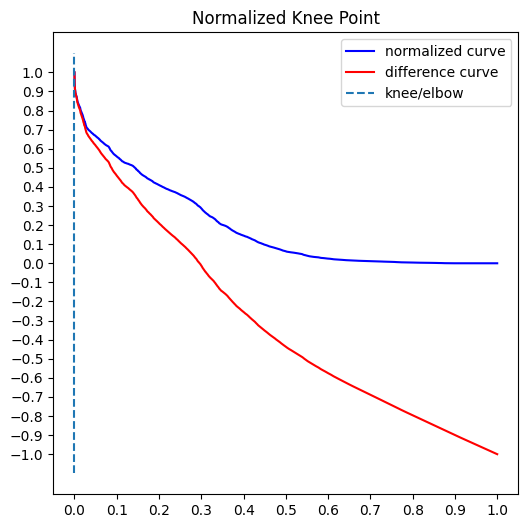

In [161]:
kneedle.plot_knee_normalized()